<a href="https://colab.research.google.com/github/jcumbicosr/processamento-linguagem-natural/blob/main/Modelo_de_Linguagem_com_auto_aten%C3%A7%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Exercício: Modelo de Linguagem com auto-atenção

Este exercício é similar ao da aula passada, mas iremos agora treinar uma rede neural *com auto-atenção* para prever a próxima palavra de um texto, data as palavras anteriores como entrada.

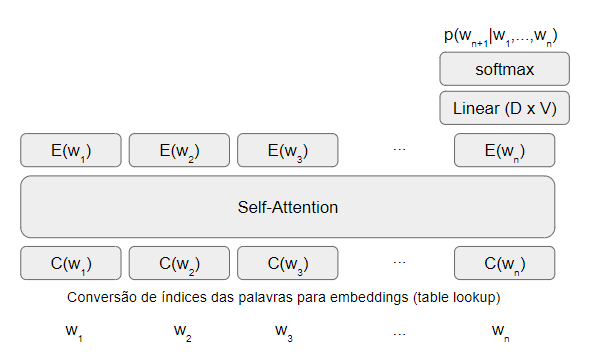

Na camada de auto-atenção, deve-se implementar (vide slide 41):
- Embeddings de posição
- Projeções lineares (WQ, WK, WV, WO)
- Camada de feed forward (2-layer MLP)



Instrucões:
- É necessário fazer duas implementações da camada de auto-atenção: uma usando laços (ineficiente, mas fácil de entender) e outra matricial (eficiente mas difícil de entender). Usar slide 41 como referência.

- Fazer um assert para garantir que o resultado das duas implementações é exatamente igual.

- No treinamento, usar apenas a implementação matricial.

In [ ]:
import os
import re
import torch
import random
import math
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from torch.nn import functional as F
from torch.nn import Embedding
from collections import Counter

### Numpy attention implementation

In [ ]:
import numpy as np

# define variables
L = 3  # length of the sequence
D = 4  # dimension of the sequence

# Create the random input data
np.random.seed(0)
seq = np.random.rand(L, D)

E = []  # list to store the attention weights

# Create the random query, key and value matrices
Wq = np.random.rand(D, D)
Wk = np.random.rand(D, D)
Wv = np.random.rand(D, D)
Wo = np.random.rand(D, D)


def loop_attention(seq, Wq, Wk, Wv, Wo):
    """
    Loop-based attention mechanism
    """
    for xq in seq:
        # Compute the query
        q = np.dot(xq, Wq)
        scores = []
        for xk in seq:
            # Compute the key
            k = np.dot(xk, Wk)
            # Compute the score
            score = np.dot(q, k)
            scores.append(score)

        # Compute the probability
        probs = np.exp(scores) / np.sum(np.exp(scores))

        # Compute the value
        e = 0
        for xv, p in zip(seq, probs):
            v = np.dot(xv, Wv)
            e += p * v

        e = np.dot(e, Wo)
        E.append(e)
    return np.array(E)


def matrix_attention(seq, Wq, Wk, Wv, Wo):
    """
    Matrix-based attention mechanism
    """
    # Compute the query, key and value matrices
    Q = np.dot(seq, Wq)
    K = np.dot(seq, Wk)
    V = np.dot(seq, Wv)

    # Compute the scores
    scores = np.matmul(Q, K.T)

    # Compute the probabilities
    probs = np.exp(scores) / np.sum(np.exp(scores), axis=1, keepdims=True)

    # Compute the values
    E = np.matmul(probs, V)

    # Compute the final output
    return np.dot(E, Wo)


# Compute the attention weights
E_loop = loop_attention(seq, Wq, Wk, Wv, Wo)
print(f'Loop-based attention weights: \n{E_loop}')
E_matrix = matrix_attention(seq, Wq, Wk, Wv, Wo)
print(f'\nMatrix-based attention weights: \n{E_matrix}')

#Check if the results are the same
assert np.allclose(E_loop, E_matrix)

Loop-based attention weights: 
[[1.75141399 0.96861121 3.1902629  0.7624445 ]
 [1.75168543 0.96823474 3.18859012 0.76226924]
 [1.75091545 0.96908755 3.19225629 0.76258807]]

Matrix-based attention weights: 
[[1.75141399 0.96861121 3.1902629  0.7624445 ]
 [1.75168543 0.96823474 3.18859012 0.76226924]
 [1.75091545 0.96908755 3.19225629 0.76258807]]


## Faz download e carrega o dataset

In [ ]:
!git clone https://github.com/ethelbeluzzi/projetomachado

Cloning into 'projetomachado'...
remote: Enumerating objects: 65, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 65 (delta 24), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (65/65), 7.21 MiB | 4.42 MiB/s, done.
Resolving deltas: 100% (24/24), done.


In [ ]:
DATA_PATH = os.path.join("projetomachado", "textonormalizado1000.txt")

min_words = 6 # Minimum number of words per line
cleaned_lines = []
line_lens = []
total_words = 0
# Abrir arquito textual e ler os dados originais
with open(DATA_PATH, "r") as data_file:
    for line in data_file:
        # Limpar linhas, removendo \n, espaços antes e depois
        line = line.strip().lower()
        # Remove punctuation marks, except , and.
        line = re.sub(r'[^\w\s,.]', '', line)
        # Apagar linhas menor que min_words
        num_words = len(line.split())
        if num_words < min_words:
            continue
        # Contador de palavras
        total_words += num_words
        cleaned_lines.append(line)
        line_lens.append(len(line))
print(f'Total de linhas: {len(cleaned_lines)}')
print(f'Total de palavras: {total_words}')
print(f'Total de caracteres: {sum(line_lens)}')

Total de linhas: 233809
Total de palavras: 3086352
Total de caracteres: 17226274


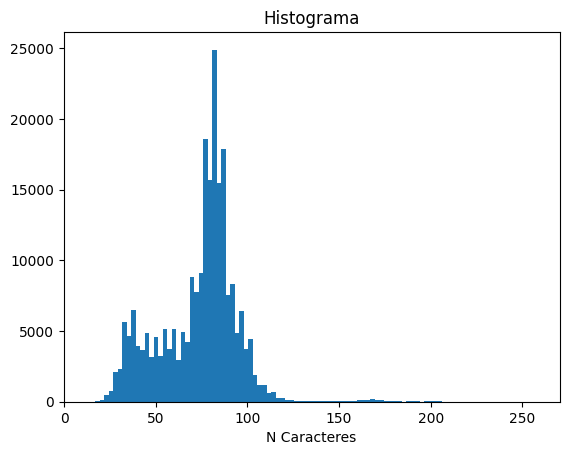

In [ ]:
plt.title("Histograma")
plt.hist(line_lens, bins=100)
plt.xlabel("N Caracteres")
plt.show()

In [ ]:
# Contar número de palavras ÚNICAS
def split_text(text):
    return re.findall(r'\w+|[.,]', text)

def count_words(texts):
    # Counter: collection especifica do Python para contar ocorrências de um objeto
    word_counts = Counter()
    for text in texts:
        # Separar em palavras, incluso caracteres de pontuação
        words = split_text(text)
        word_counts.update(words)
        #### Separado com regex, \w+: sequências alfanuméricas
    return word_counts

word_counts = count_words(cleaned_lines)

len(word_counts)

72140

## Criando um vocabulário

In [ ]:
VOCAB_SIZE = 2000
most_frequent_words = [word for word, count in word_counts.most_common(VOCAB_SIZE)]
vocab = {word: i for i, word in enumerate(most_frequent_words, 1)}
vocab['<unk>'] = 0

In [ ]:
# Função de tokenização
def encode_sentence(sentence, vocab):
    # Usa regex para separar palavras (sequências alfa numéricas)
    return [vocab.get(word, 0) for word in split_text(sentence)]

random_sentence = random.choice(cleaned_lines)
encoded_sentence = encode_sentence(random_sentence, vocab)
print(f"{random_sentence}\n{encoded_sentence}")

fim único de lhe matar as horas aborrecidas. e merecia esse favor, pois de madrugada,
[148, 592, 5, 31, 1910, 20, 173, 0, 2, 6, 0, 132, 844, 1, 200, 5, 0, 1]


## Classe do dataset

In [ ]:
from torch.utils.data import Dataset, DataLoader

context_size = 5 # 5 palavras de entrada. O target é a próxima palavra

"""TODO: Preparar o dataset"""

class MachadoDataset(Dataset):
    def __init__(self, text, vocab, context_size=5):
        self.vocab = vocab
        self.context_size = context_size

        mono_text = []
        self.source = []
        self.target = []
        for line in text:
            tokens = encode_sentence(line, vocab)
            mono_text.extend(tokens)

        # Sliding windows
        for i in range(len(mono_text)-context_size-1):
            data = mono_text[i:i+context_size+1]
            # Delete if data contain <ukn> token
            if 0 in data:
                continue
            self.source.append(data[:-1])
            self.target.append(data[-1])

    def __len__(self):
        return len(self.source)

    def __getitem__(self, idx):
        return torch.tensor(self.source[idx]), torch.tensor(self.target[idx])

my_dataset = MachadoDataset(cleaned_lines, vocab, context_size)
sample = my_dataset[0]
print(f'Length of Dataset: {len(my_dataset)}')
print('==> Sample <==')
print(f'Source: {sample[0]}')
print(f'Target: {sample[1]}')

Length of Dataset: 1044813
==> Sample <==
Source: tensor([497,   1, 796,   2,   8])
Target: 16


In [ ]:
"""TODO: divida o dataset em validação/treino com um proporção de 20/80 %. OBS, use random_state=18"""

from sklearn.model_selection import train_test_split

# Split the dataset into training and validation sets
train_data, val_data = train_test_split(my_dataset, test_size=0.2, random_state=18)

In [ ]:
batch_size = 128
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)

sample = next(iter(train_loader))
print(f'Shape of source: {sample[0].shape}')
print(f'Shape of target: {sample[1].shape}')

Shape of source: torch.Size([128, 5])
Shape of target: torch.Size([128])


## Model

In [ ]:

class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(
            0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)

        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Arguments:
            x: Tensor, shape ``[batch_size, seq_len, embedding_dim]``
        """
        x = x + self.pe[:, :x.size(1), :]
        return x

class LanguageModel(nn.Module):
    """Attention layer using loop and matrix implementation"""

    def __init__(self, vocab_size, d_model, seq_len, hidden_size, dropout=0.3):
        super(LanguageModel, self).__init__()

        self.d_model = d_model
        # Create query, key and value matrix
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

        # Initialize embedding layer
        self.embedding = nn.Embedding(vocab_size, d_model)

        # Initialize the positional encoding
        self.pe = PositionalEncoding(d_model, seq_len)

        # Initialize dropout layer
        self.dropout = nn.Dropout(dropout)

        # Initialize last linear layers
        self.fc1 = nn.Linear(d_model * seq_len, hidden_size)
        self.fc2 = nn.Linear(hidden_size, vocab_size)


    def loop_attention(self, Q, K, V):
        """TODO: attention versão loop"""
        # Initialize the output tensor
        output = torch.zeros_like(Q)
        # Loop over the sequence length
        for i in range(Q.size(1)):
            # Compute the attention scores
            q = self.W_q(Q[:, i, :]).unsqueeze(1)
            scores = torch.tensor([])
            for j in range(K.size(1)):
                k = self.W_k(K[:, j, :].unsqueeze(1))
                score = torch.matmul(q, k.transpose(-2, -1)).squeeze(-1)
                scores = torch.cat((scores, score), dim=1)
            # Compute the probabilities
            probs = nn.functional.softmax(scores, dim=-1)
            # Compute the weighted sum
            # e = torch.zeros(V.size(1))
            e = torch.tensor([])
            for j in range(V.size(1)):
                v = self.W_v(V[:, j, :].unsqueeze(1))
                aux = torch.matmul(probs[:, j].unsqueeze(1).unsqueeze(2), v)
                e = torch.cat((e, aux), dim=1)
            # Compute the output
            output[:, i, :] = self.W_o(e.sum(dim=1).squeeze(1))

        return output

    def matrix_attention(self, Q, K, V):
        """TODO: attention versão matricial"""
        # Linear projections
        Q = self.W_q(Q)
        K = self.W_k(K)
        V = self.W_v(V)

        # Compute attention scores
        scores = torch.matmul(Q, K.transpose(-2, -1))
        # Compute the probabilties
        probs = nn.functional.softmax(scores, dim=-1)
        # Compute the weighted sum
        output = torch.matmul(probs, V)
        # Apply the output linear layer
        output = self.W_o(output)
        return output

    # interessante ter uma flag para indicar qual a versão usada (loop ou matricial)
    def forward(self, x, matrix=True):
        # Embedding
        x = self.embedding(x)

        # Apply positional encoding
        x = self.pe(x)

        # Apply attention
        if matrix:
            attn = self.matrix_attention(x, x, x)
        else:
            attn = self.loop_attention(x, x, x)

        # Flatten the embeddings into a single vector
        attn = attn.view(attn.size(0), -1)  # (batch_size, context_size * embed_size)
        #attn = self.dropout(attn)

        # Final layers
        output = F.relu(self.fc1(attn))
        output = self.fc2(self.dropout(output))
        return output

In [ ]:
# Define hyperparameters
vocab_size = len(vocab)+1  # Size of the vocabulary
d_model = 64              # Dimension of model
#context_size = 5          # Number of context words
hidden_size = 512          # Number of neurons in the hidden layer

# Model instantiation
model = LanguageModel(vocab_size, d_model, context_size, hidden_size)

print(model)
# Count number of parameters
print("\nParameters by layer:")
for p in model.parameters():
    print(p.shape)

total_params = sum(p.numel() for p in model.parameters())
print(f"\nTotal number of parameters: {total_params}")

LanguageModel(
  (W_q): Linear(in_features=64, out_features=64, bias=True)
  (W_k): Linear(in_features=64, out_features=64, bias=True)
  (W_v): Linear(in_features=64, out_features=64, bias=True)
  (W_o): Linear(in_features=64, out_features=64, bias=True)
  (embedding): Embedding(2002, 64)
  (pe): PositionalEncoding()
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=320, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2002, bias=True)
)

Parameters by layer:
torch.Size([64, 64])
torch.Size([64])
torch.Size([64, 64])
torch.Size([64])
torch.Size([64, 64])
torch.Size([64])
torch.Size([64, 64])
torch.Size([64])
torch.Size([2002, 64])
torch.Size([512, 320])
torch.Size([512])
torch.Size([2002, 512])
torch.Size([2002])

Total number of parameters: 1336146


In [ ]:
sample = next(iter(train_loader))
input = sample[0]
target = sample[1]


output1 = model(input, matrix=True)  # Usa a versão matricial
output2 = model(input, matrix=False)  # Usa a versão loop

print(f'Shape of output1: {output1.shape}')
print(f'Shape of output2: {output2.shape}')

# Verifica se as saídas são iguais
are_equal = torch.allclose(output1, output2, atol=1e-6)  # Verifica se os resultados são próximos
if are_equal:
    print("As saídas são iguais.")
else:
    print("As saídas são diferentes!!!")

Shape of output1: torch.Size([128, 2002])
Shape of output2: torch.Size([128, 2002])
As saídas são iguais.


## Training

In [ ]:
# Verifica se há uma GPU disponível e define o dispositivo para GPU se possível, caso contrário, usa a CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
import time

epochs = 15
lr = 5e-4; """TODO, experimente!"""
criterion = nn.CrossEntropyLoss(); """TODO CrossEntropy"""

# Model instantiatio
model = LanguageModel(vocab_size, d_model, context_size, hidden_size)
# Move the model to the appropriate device (GPU or CPU)
model.to(device)


#optimizer = torch.optim.Adam(model.parameters(), lr=lr); """TODO: AdamW ou outro, experimente!"""
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

"""TODO: Implemente o loop de treinamento. Em cada época, calcule e imprima a loss no dataset de validação. Opcional: Plote um gráfico da loss de validação e treino"""

def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    test_acc = 0.0
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        logits = model(inputs)
        loss = criterion(logits, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        preds = logits.argmax(dim=1)
        accuracy = (preds == targets).float().mean()
        test_acc += accuracy.item()

    return total_loss / len(train_loader), (test_acc / len(train_loader)) * 100

def valid_epoch(model, valid_loader, criterion, device):
    ## evaluation
    val_acc = 0
    val_loss = 0
    model.eval()
    with torch.no_grad():
        for inputs, targets in valid_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            logits = model(inputs)

            # Calculate loss
            loss = criterion(logits, targets)
            val_loss += loss.item()

            # Calculate acc
            preds = logits.argmax(dim=1)
            accuracy = (preds == targets).float().mean()
            val_acc += accuracy.item()

    return val_loss / len(val_loader), (val_acc / len(val_loader)) * 100

# Save history to dictionnary
history = {
    'train_loss': [],
    'eval_loss': [],
    'train_acc': [],
    'eval_acc': []
}

# Initial evaluation
val_loss, val_acc = valid_epoch(model, val_loader, criterion, device)
perplexity = torch.exp(torch.tensor(val_loss))
print(f'[Initial] Test loss:{val_loss:.4f}, Test acc:{val_acc:.2f}%, Perplexity:{perplexity:.2f}')

# Training loop
for epoch in range(epochs):
    start_time_epoch = time.time()  # Start time of the epoch

    # train model
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)

    # evaluate model
    val_loss, val_acc = valid_epoch(model, val_loader, criterion, device)

    end_time = time.time()  # End time of the epoch
    epoch_duration = end_time - start_time_epoch  # Duration of epoch

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['eval_loss'].append(val_loss)
    history['eval_acc'].append(val_acc)

    perplexity = torch.exp(torch.tensor(val_loss))
    print(f'Epoch [{epoch+1}/{epochs}], Train loss:{train_loss:.4f}, Train acc:{train_acc:.2f}%, '
          f'Test loss:{val_loss:.4f}, Test acc: {val_acc:.2f}%, '
          f'Perplexity:{perplexity:.2f}, Elapsed Time: {epoch_duration:.2f} sec')

[Initial] Test loss:7.6005, Test acc:0.08%, Perplexity:1999.21
Epoch [1/15], Train loss:4.9425, Train acc:13.50%, Test loss:4.6252, Test acc: 15.65%, Perplexity:102.03, Elapsed Time: 25.46 sec
Epoch [2/15], Train loss:4.5507, Train acc:16.01%, Test loss:4.4724, Test acc: 16.80%, Perplexity:87.56, Elapsed Time: 25.21 sec
Epoch [3/15], Train loss:4.4156, Train acc:16.89%, Test loss:4.3917, Test acc: 17.48%, Perplexity:80.77, Elapsed Time: 25.07 sec
Epoch [4/15], Train loss:4.3245, Train acc:17.38%, Test loss:4.3448, Test acc: 17.78%, Perplexity:77.08, Elapsed Time: 24.97 sec
Epoch [5/15], Train loss:4.2543, Train acc:17.82%, Test loss:4.3087, Test acc: 18.18%, Perplexity:74.34, Elapsed Time: 25.12 sec
Epoch [6/15], Train loss:4.1973, Train acc:18.19%, Test loss:4.2833, Test acc: 18.45%, Perplexity:72.48, Elapsed Time: 25.88 sec
Epoch [7/15], Train loss:4.1500, Train acc:18.55%, Test loss:4.2677, Test acc: 18.63%, Perplexity:71.36, Elapsed Time: 25.07 sec
Epoch [8/15], Train loss:4.1112, 

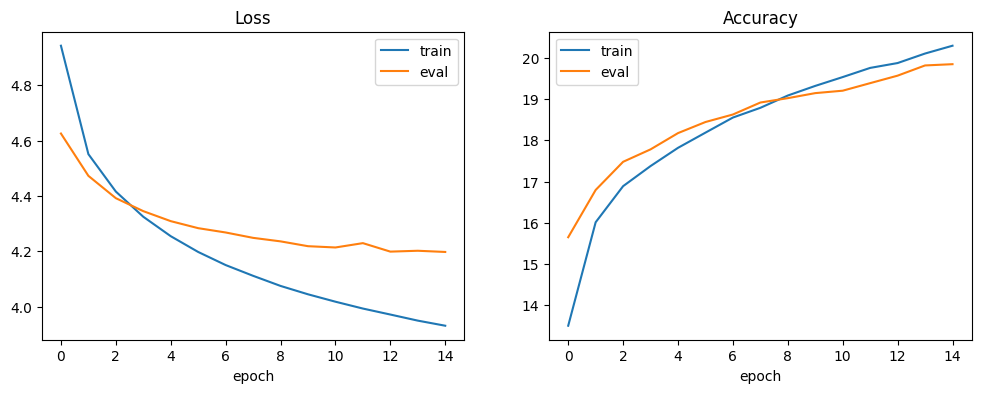

In [ ]:
# Plot loss and accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='train')
plt.plot(history['eval_loss'], label='eval')
plt.legend()
plt.title('Loss')
plt.xlabel('epoch')
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='train')
plt.plot(history['eval_acc'], label='eval')
plt.legend()
plt.title('Accuracy')
plt.xlabel('epoch')
plt.show()

## Exemplo de uso

In [ ]:
"""TODO: implemente a função para gerar texto até atingir o max_length"""

class NextWord(nn.Module):
    def __init__(self, language_model, vocab, context_size):
        super(NextWord, self).__init__()
        self.model = language_model
        self.context_size = context_size
        self.vocab = vocab
        self.inverse_vocab = {i: word for word, i in vocab.items()}

    def str_to_tokens(self, sentence):
        return [self.vocab.get(word, 0) for word in split_text(sentence)]

    def tokens_to_str(self, tokens):
        return ' '.join(self.inverse_vocab[token] for token in tokens)

    def __call__(self, text, max_length):
        input = torch.tensor(self.str_to_tokens(text)).to(device)
        self.model.eval()
        print('Output: ', end='')
        for step in range(len(input), max_length):
             # Calculate the start index for slicing; ensure it's not negative
             start_idx = max(0, step - self.context_size)
             # Slice the input tensor to get the context
             context = input[start_idx:step].unsqueeze(0)

             logits = self.model(context)
             output = logits.argmax(dim=1)

             #print(f"Context: {context.tolist()} | Output: {output.tolist()}")
             print(output.tolist(), end=' ')

             input = torch.cat((input, output))

        return self.tokens_to_str(input.tolist())



next_word = NextWord(model, vocab, context_size)

print(f'\n===========> Test <===========')
text = "bom dia, tudo bem"
max_length= 100
next_word(text, max_length)


===========> Test <===========
Output: [1] [6] [3] [56] [363] [1] [6] [3] [56] [363] [1] [6] [3] [56] [363] [1] [6] [3] [56] [363] [1] [6] [3] [56] [363] [1] [6] [3] [56] [363] [1] [6] [3] [56] [363] [1] [6] [3] [56] [363] [1] [6] [3] [56] [363] [1] [6] [3] [56] [363] [1] [6] [3] [56] [363] [1] [6] [3] [56] [363] [1] [6] [3] [56] [363] [1] [6] [3] [56] [363] [1] [6] [3] [56] [363] [1] [6] [3] [56] [363] [1] [6] [3] [56] [363] [1] [6] [3] [56] [363] [1] [6] [3] [56] [363] 

'bom dia , tudo bem , e a minha história , e a minha história , e a minha história , e a minha história , e a minha história , e a minha história , e a minha história , e a minha história , e a minha história , e a minha história , e a minha história , e a minha história , e a minha história , e a minha história , e a minha história , e a minha história , e a minha história , e a minha história , e a minha história'

In [ ]:
print(f'===========> Test <===========')
text = "que é uma boa literatura"
max_length= 150
next_word(text, max_length)

===========> Test <===========
Output: [6] [3] [56] [120] [1] [6] [3] [56] [363] [1] [6] [3] [56] [363] [1] [6] [3] [56] [363] [1] [6] [3] [56] [363] [1] [6] [3] [56] [363] [1] [6] [3] [56] [363] [1] [6] [3] [56] [363] [1] [6] [3] [56] [363] [1] [6] [3] [56] [363] [1] [6] [3] [56] [363] [1] [6] [3] [56] [363] [1] [6] [3] [56] [363] [1] [6] [3] [56] [363] [1] [6] [3] [56] [363] [1] [6] [3] [56] [363] [1] [6] [3] [56] [363] [1] [6] [3] [56] [363] [1] [6] [3] [56] [363] [1] [6] [3] [56] [363] [1] [6] [3] [56] [363] [1] [6] [3] [56] [363] [1] [6] [3] [56] [363] [1] [6] [3] [56] [363] [1] [6] [3] [56] [363] [1] [6] [3] [56] [363] [1] [6] [3] [56] [363] [1] [6] [3] [56] [363] [1] [6] [3] [56] [363] [1] 

'que é uma boa literatura e a minha mãe , e a minha história , e a minha história , e a minha história , e a minha história , e a minha história , e a minha história , e a minha história , e a minha história , e a minha história , e a minha história , e a minha história , e a minha história , e a minha história , e a minha história , e a minha história , e a minha história , e a minha história , e a minha história , e a minha história , e a minha história , e a minha história , e a minha história , e a minha história , e a minha história , e a minha história , e a minha história , e a minha história , e a minha história ,'

In [ ]:
print(f'===========> Test <===========')
text = "mas o que é verdade"
max_length= 130
next_word(text, max_length)

===========> Test <===========
Output: [1] [6] [3] [90] [7] [4] [13] [4] [7] [8] [13] [4] [7] [8] [13] [4] [7] [8] [13] [4] [7] [8] [13] [4] [7] [8] [13] [4] [7] [8] [13] [4] [7] [8] [13] [4] [7] [8] [13] [4] [7] [8] [13] [4] [7] [8] [13] [4] [7] [8] [13] [4] [7] [8] [13] [4] [7] [8] [13] [4] [7] [8] [13] [4] [7] [8] [13] [4] [7] [8] [13] [4] [7] [8] [13] [4] [7] [8] [13] [4] [7] [8] [13] [4] [7] [8] [13] [4] [7] [8] [13] [4] [7] [8] [13] [4] [7] [8] [13] [4] [7] [8] [13] [4] [7] [8] [13] [4] [7] [8] [13] [4] [7] [8] [13] [4] [7] [8] [13] [4] [7] [8] [13] [4] [7] 

'mas o que é verdade , e a quem o que é que o não é que o não é que o não é que o não é que o não é que o não é que o não é que o não é que o não é que o não é que o não é que o não é que o não é que o não é que o não é que o não é que o não é que o não é que o não é que o não é que o não é que o não é que o não é que o não é que o não é que o não é que o não é que o não é que o não é que o'

In [ ]:
print(f'===========> Test <===========')
text = "o chapéu grande precisa de"
max_length= 120
next_word(text, max_length)

===========> Test <===========
Output: [9] [60] [1] [6] [3] [56] [363] [1] [6] [3] [56] [363] [1] [6] [3] [56] [363] [1] [6] [3] [56] [363] [1] [6] [3] [56] [363] [1] [6] [3] [56] [363] [1] [6] [3] [56] [363] [1] [6] [3] [56] [363] [1] [6] [3] [56] [363] [1] [6] [3] [56] [363] [1] [6] [3] [56] [363] [1] [6] [3] [56] [363] [1] [6] [3] [56] [363] [1] [6] [3] [56] [363] [1] [6] [3] [56] [363] [1] [6] [3] [56] [363] [1] [6] [3] [56] [363] [1] [6] [3] [56] [363] [1] [6] [3] [56] [363] [1] [6] [3] [56] [363] [1] [6] [3] [56] [363] [1] [6] [3] [56] [363] [1] [6] [3] 

'o chapéu grande precisa de um dia , e a minha história , e a minha história , e a minha história , e a minha história , e a minha história , e a minha história , e a minha história , e a minha história , e a minha história , e a minha história , e a minha história , e a minha história , e a minha história , e a minha história , e a minha história , e a minha história , e a minha história , e a minha história , e a minha história , e a minha história , e a minha história , e a minha história , e a'

In [ ]:
print(f'===========> Test <===========')
text = "excelente dia para ficar em"
max_length= 130
next_word(text, max_length)

===========> Test <===========
Output: [4] [7] [159] [32] [8] [1048] [5] [9] [60] [1] [6] [3] [56] [363] [1] [6] [3] [56] [363] [1] [6] [3] [56] [363] [1] [6] [3] [56] [363] [1] [6] [3] [56] [363] [1] [6] [3] [56] [363] [1] [6] [3] [56] [363] [1] [6] [3] [56] [363] [1] [6] [3] [56] [363] [1] [6] [3] [56] [363] [1] [6] [3] [56] [363] [1] [6] [3] [56] [363] [1] [6] [3] [56] [363] [1] [6] [3] [56] [363] [1] [6] [3] [56] [363] [1] [6] [3] [56] [363] [1] [6] [3] [56] [363] [1] [6] [3] [56] [363] [1] [6] [3] [56] [363] [1] [6] [3] [56] [363] [1] [6] [3] [56] [363] [1] [6] [3] [56] [363] [1] [6] [3] [56] [363] [1] 

'excelente dia para ficar em que o senhor me não fizesse de um dia , e a minha história , e a minha história , e a minha história , e a minha história , e a minha história , e a minha história , e a minha história , e a minha história , e a minha história , e a minha história , e a minha história , e a minha história , e a minha história , e a minha história , e a minha história , e a minha história , e a minha história , e a minha história , e a minha história , e a minha história , e a minha história , e a minha história , e a minha história ,'